<a href="https://colab.research.google.com/github/densaiko/NLP_Experiment/blob/main/NLP_Machine%20Learning%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 2 - Machine Learning 2 (Model Deployment)
by: Ari Sulistiyo Prabowo - Data Engineer Fellow

#Content

**1. Data Preparation**
  - Load the data 

**2. Exploratory Data Analysis (EDA)**
  - The most frequent words appear

**3. Data Preprocessing**
  - Handling the unimportant words

**4. Modelling**
  - Create various model

**5. Experiment Testing**

    5.1. Stemmer using PorterStemmer and MultinomialNB model
    5.2. Stemmer using PorterStemmer and Logistic Regression model
    5.3. Stemmer using PorterStemmer, apply stopwords, and MultinomialNB model
    5.4. Stemmer using SnowballStemmer and MultinomialNB model
    5.5. Stemmer using SnowballStemmer and Logistic Regression model
    5.6. Stemmer using SnowballStemmer, apply stopwords, and MultinomialNB model
    5.7. Stemmer using LancasterStemmer and MultinomialNB model
    5.8. Stemmer using LancasterStemmer and Logistic Regression model
    5.9. Stemmer using LancasterStemmer, apply stopwords, and MultinomialNB model
    5.10. Stemmer using PorterStemmer, Bag of Work, and MultinomialNB model
    5.11. Stemmer using SnowballStemmer, Bag of Work, and MultinomialNB model 
    5.12. Stemmer using LancasterStemmer, Bag of Work, and MultinomialNB model 
    5.13. Stemmer using LancasterStemmer, Bag of Work, and Logistic Regression model

##**1. Data Preparation**

In [3]:
#Import library
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
import time
import string
import pickle
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
df = pd.read_csv('/content/drive/MyDrive/Data Ari/Data Science/IYKRA/Machine Learning 2 (Model Deployment)/tweets.csv',
                 encoding='ISO-8859-1', header=None)

#take the variable 0 as a sentiment and 5 as a tweet, and then change the variable name
df = df.rename(columns={0:'sentiment',5:'tweet'})
df = df[['sentiment','tweet']]

#change the value 0 for negative and 4 for positive
df = df.replace({'sentiment':{0:'Negative', 4:'Positive'}})

#show the first five data
display(df.shape)
df.head()

(100000, 2)

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Well, the data is quite big around 100.000 rows

In [122]:
#brief information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  100000 non-null  object
 1   tweet      100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [123]:
#check the class
df.sentiment.value_counts()

Positive    50000
Negative    50000
Name: sentiment, dtype: int64

The data looks good that there is no null values 

##**2. Exploratory Data Analysis**

In [124]:
#stopwords are used to remove any redundant words
stopwords = set(STOPWORDS)

#setting the wordcloud
words_comment = WordCloud(background_color = 'white', max_words = 3000,
                          stopwords = stopwords)

#generate the word cloud
text = " ".join(news for news in df['tweet'])
words_comment.generate(text)

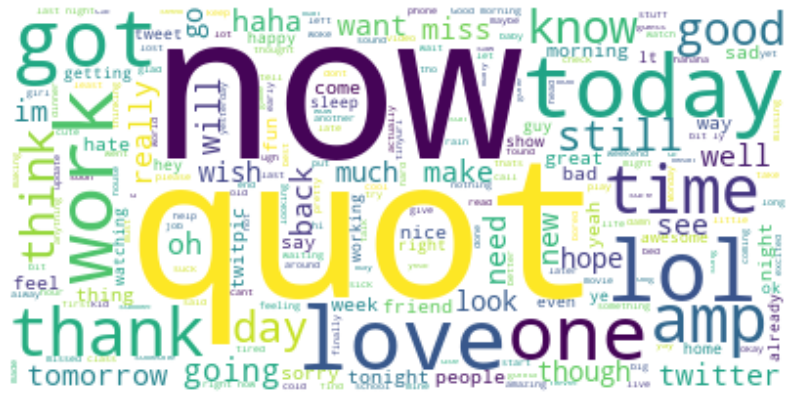

In [125]:
#show the generated image
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)
plt.imshow(words_comment, interpolation='bilinear')
plt.axis('off')
plt.show()

The words appear the most do not shows the specific meaning. It could be in the workplace, but it is talking also about love. 

In my assumption, this is a random conversation. Therefore, it is hard to know the category of the conversation at the first place.

##**3. Data Preprocessing**
In this section, there are several pre-processing steps:
1. Remove the quotation, new lines, and the link form
2. Replace hastag (#) and username into __userhandle__
3. Remove repeating character
4. Apply the stemmer

In [4]:
def preprocess(tweet,  stemmmer, do_stem=True):
    # Convert to lower case
    tweet = tweet.lower()

    # Remove all quotations: ' and "
    tweet = tweet.strip('\'"')

    # Remove newlines
    tweet = tweet.strip('\n')

    # Convert links in the form of www.* or https?://* to "URL"
    # e.g. www.google.com -> "URL". Why?
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)

    # Convert @username to __userhandle__
    # e.g. @geraldzakwan -> __userhandle__. Why?
    tweet = re.sub('@[^\s]+','__userhandle__',tweet)

    # Replace hashtag: #word with the word itself
    # e.g. #liverpool -> liverpool. Why?
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # Remove repeating chars
    # e.g. helloooo -> hello
    repeat_char = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = repeat_char.sub(r"\1\1", tweet)

    # List of positive and negative emoticons
    emoticons = \
    [
     ('__positive__',[ ':-)', ':)', '(:', '(-:', \
                       ':-D', ':D', 'X-D', 'XD', 'xD', \
                       '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
     ('__negative__', [':-(', ':(', '(:', '(-:', ':,(',\
                       ':\'(', ':"(', ':((','D:' ] ),\
    ]

    def replace_parenthesis(arr):
       return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

    def join_parenthesis(arr):
        return '(' + '|'.join( arr ) + ')'

    # Build emoticon regex
    emoticons_regex = [(repl, re.compile(join_parenthesis(replace_parenthesis(regx)))) \
                        for (repl, regx) in emoticons]

    # Replace positive emoticons with "__positive__"
    # and negative emoticons with "__negative__"
    for (repl, regx) in emoticons_regex:
        tweet = re.sub(regx, ' ' + repl + ' ', tweet)

    if do_stem:
        tweet = stem(stemmmer, tweet)

    return tweet

    # Stem using PorterStemmer from NLTK
def stem(stemmmer, tweet):
    # NOTE: You can play with this, i.e. try other stemmer types!
    stemmer = stemmmer

    # Simply tokenize by space
    words = [word for word in tweet.split()]

    # Stem each token
    words = [stemmer.stem(w) for w in words]

    # Rejoin them
    return ' '.join(words)

##**4. Modelling**

In this section, the data is load and applied the pre-processing steps and directly applied the model.

In [5]:
# This function is speficic for Sentiment140 dataset
def load_dataset():
    # Read data/tweets_100k/positive.txt
    with open("/content/drive/MyDrive/Data Ari/Data Science/IYKRA/Machine Learning 2 (Model Deployment)/positive.txt", "r") as infile:
        positive_tweets = infile.readlines()

    # Do the same with negative tweets
    with open("/content/drive/MyDrive/Data Ari/Data Science/IYKRA/Machine Learning 2 (Model Deployment)/negative.txt", "r") as infile:
        negative_tweets = infile.readlines()

    X = negative_tweets + positive_tweets
    y = np.concatenate([np.full(len(negative_tweets), 0), np.full(len(positive_tweets), 4)])

    return X, y

def prepare_data(X, y, stemmmer, test_size):
    # 80/20 train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=28)

    # Preprocess pipeline (see preprocess.py), convert sentences to their numerical representation
    X_train = [preprocess(tweet, stemmmer=stemmmer, do_stem=True) for tweet in X_train]
    X_test = [preprocess(tweet, stemmmer=stemmmer, do_stem=True) for tweet in X_test]

    return X_train, X_test, y_train, y_test

def process_text(tweet):
    from nltk.corpus import stopwords 
    from nltk.tokenize import word_tokenize
    
    # #remove the punction that is not important
    # nopunc = [char for char in tweet if char not in string.punctuation]
    # nopunc = ''.join(nopunc)
    # nopunc = nopunc.lower()
    
    #remove useless word in data
    stop_words = set(stopwords.words('english')) 
    
    word_tokens = word_tokenize(tweet) 
    
    clean_words = [w for w in word_tokens if not w in stop_words] 
    return clean_words

def extract_feature(X, vec, fit):
    # Fit means that we train our extractor using the data (do this with train data)
    if fit:
        return vec.fit_transform(X)

    # No fit means that we only apply extraction to the data (do this with test data)
    return vec.transform(X)

def train(cls, X, y):
    return cls.fit(X, y)

def predict(cls, X):
    return cls.predict(X)

def get_pred_statistics(y, pred):
    print("Accuracy: {:.2f}".format(metrics.accuracy_score(y, pred)*100))
    print()

    print("Confusion matrix:")
    print(metrics.confusion_matrix(y, pred))
    print()

    cm = metrics.confusion_matrix(y, pred)

    print("Classification report:")
    print(metrics.classification_report(y, pred))
    print()

def main(extractor, classifier, stemmmer):
    # To log the training time
    start = time.time()

    X, y = load_dataset()

    X_train, X_test, y_train, y_test = prepare_data(X, y, stemmmer, test_size=0.2)

    # Use TF-IDF as feature extractor
    # NOTE: You can play with this, i.e. try other extractors or change hyperparameters!
    extractor = extractor

    # Apply feature extractor, e.g. TF-IDF, on train data
    X_train_vec = extract_feature(X_train, extractor, fit=True)

    # Define your classifier, e.g. Naive Bayes
    # NOTE: You can play with this, i.e. try other classifiers or change hyperparameters!
    classifier = classifier

    train(classifier, X_train_vec, y_train)

    print("*"*50)
    print()

    print("Training finish in {:.2f} seconds".format(time.time() - start))
    print()

    print("Statistics using train data:")
    print()

    # Get prediction on training data
    pred = predict(classifier, X_train_vec)

    get_pred_statistics(y_train, pred)

    print("*"*50)
    print()

    print("Statistics using test data:")
    print()

    # Apply TF-IDF on test data
    # IMPORTANT: Don't fit again, just transform! Why?
    X_test_vec = extract_feature(X_test, extractor, fit=False)

    # Get prediction on training data
    pred = predict(classifier, X_test_vec)

    get_pred_statistics(y_test, pred)

    print("*"*50)
    print()

##**5.Experiment Testing**

###**5.1. Stemmer using PorterStemmer and MultinomialNB model**

In [128]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=PorterStemmer())

**************************************************

Training finish in 41.26 seconds

Statistics using train data:

Accuracy: 84.40

Confusion matrix:
[[34218  5838]
 [ 6645 33299]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     40056
           4       0.85      0.83      0.84     39944

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000


**************************************************

Statistics using test data:

Accuracy: 78.61

Confusion matrix:
[[7906 2038]
 [2240 7816]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9944
           4       0.79      0.78      0.79     10056

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79    

###**5.2. Stemmer using PorterStemmer and Gradient Boosting model**

In [129]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=LogisticRegression(), stemmmer=PorterStemmer())

**************************************************

Training finish in 44.09 seconds

Statistics using train data:

Accuracy: 85.81

Confusion matrix:
[[34269  5787]
 [ 5562 34382]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     40056
           4       0.86      0.86      0.86     39944

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000


**************************************************

Statistics using test data:

Accuracy: 79.78

Confusion matrix:
[[7879 2065]
 [1978 8078]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      9944
           4       0.80      0.80      0.80     10056

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80    

###**5.3. Stemmer using PorterStemmer, apply stopwords, and MultinomialNB model**

In [133]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(analyzer=process_text, min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=PorterStemmer())

**************************************************

Training finish in 57.14 seconds

Statistics using train data:

Accuracy: 79.59

Confusion matrix:
[[32050  8006]
 [ 8324 31620]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     40056
           4       0.80      0.79      0.79     39944

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000


**************************************************

Statistics using test data:

Accuracy: 76.19

Confusion matrix:
[[7603 2341]
 [2421 7635]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9944
           4       0.77      0.76      0.76     10056

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76    

###**5.4. Stemmer using SnowballStemmer and MultinomialNB model**

In [134]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=SnowballStemmer('english'))

**************************************************

Training finish in 34.44 seconds

Statistics using train data:

Accuracy: 84.39

Confusion matrix:
[[34203  5853]
 [ 6639 33305]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     40056
           4       0.85      0.83      0.84     39944

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000


**************************************************

Statistics using test data:

Accuracy: 78.63

Confusion matrix:
[[7915 2029]
 [2245 7811]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9944
           4       0.79      0.78      0.79     10056

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79    

###**5.5. Stemmer using SnowballStemmer and Logistic Regression model**

In [135]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=LogisticRegression(), stemmmer=SnowballStemmer("english"))

**************************************************

Training finish in 37.05 seconds

Statistics using train data:

Accuracy: 85.90

Confusion matrix:
[[34300  5756]
 [ 5525 34419]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     40056
           4       0.86      0.86      0.86     39944

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000


**************************************************

Statistics using test data:

Accuracy: 79.73

Confusion matrix:
[[7876 2068]
 [1985 8071]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      9944
           4       0.80      0.80      0.80     10056

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80    

###**5.6. Stemmer using SnowballStemmer, apply stopwords, and MultinomialNB model**

In [136]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(analyzer=process_text, min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=SnowballStemmer("english"))

**************************************************

Training finish in 49.40 seconds

Statistics using train data:

Accuracy: 79.57

Confusion matrix:
[[32027  8029]
 [ 8313 31631]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80     40056
           4       0.80      0.79      0.79     39944

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000


**************************************************

Statistics using test data:

Accuracy: 75.97

Confusion matrix:
[[7571 2373]
 [2434 7622]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9944
           4       0.76      0.76      0.76     10056

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76    

###**5.7. Stemmer using LancasterStemmer and MultinomialNB model**

In [137]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=LancasterStemmer())

**************************************************

Training finish in 32.78 seconds

Statistics using train data:

Accuracy: 84.37

Confusion matrix:
[[34215  5841]
 [ 6664 33280]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     40056
           4       0.85      0.83      0.84     39944

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000


**************************************************

Statistics using test data:

Accuracy: 78.30

Confusion matrix:
[[7872 2072]
 [2269 7787]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      9944
           4       0.79      0.77      0.78     10056

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78    

###**5.8. Stemmer using LancasterStemmer and Logistic Regression model**

In [138]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=LogisticRegression(), stemmmer=LancasterStemmer())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**************************************************

Training finish in 36.48 seconds

Statistics using train data:

Accuracy: 85.70

Confusion matrix:
[[34256  5800]
 [ 5643 34301]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     40056
           4       0.86      0.86      0.86     39944

    accuracy                           0.86     80000
   macro avg       0.86      0.86      0.86     80000
weighted avg       0.86      0.86      0.86     80000


**************************************************

Statistics using test data:

Accuracy: 79.66

Confusion matrix:
[[7870 2074]
 [1993 8063]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      9944
           4       0.80      0.80      0.80     10056

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80    

###**5.9. Stemmer using LancasterStemmer, apply stopwords, and MultinomialNB model**

In [139]:
if __name__ == '__main__':
    main(extractor = TfidfVectorizer(analyzer=process_text, min_df=5, use_idf=True, ngram_range=(1, 4)),
         classifier=MultinomialNB(), stemmmer=LancasterStemmer())

**************************************************

Training finish in 48.50 seconds

Statistics using train data:

Accuracy: 79.26

Confusion matrix:
[[31866  8190]
 [ 8402 31542]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     40056
           4       0.79      0.79      0.79     39944

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000


**************************************************

Statistics using test data:

Accuracy: 76.09

Confusion matrix:
[[7565 2379]
 [2402 7654]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9944
           4       0.76      0.76      0.76     10056

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76    

###**5.10. Stemmer using PorterStemmer, Bag of Work, and MultinomialNB model**

In [140]:
if __name__ == '__main__':
    main(extractor = CountVectorizer(),
         classifier=MultinomialNB(), stemmmer=PorterStemmer())

**************************************************

Training finish in 28.61 seconds

Statistics using train data:

Accuracy: 83.49

Confusion matrix:
[[34212  5844]
 [ 7366 32578]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84     40056
           4       0.85      0.82      0.83     39944

    accuracy                           0.83     80000
   macro avg       0.84      0.83      0.83     80000
weighted avg       0.84      0.83      0.83     80000


**************************************************

Statistics using test data:

Accuracy: 76.81

Confusion matrix:
[[7848 2096]
 [2541 7515]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9944
           4       0.78      0.75      0.76     10056

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77    

###**5.11. Stemmer using SnowballStemmer, Bag of Work, and MultinomialNB**

In [141]:
if __name__ == '__main__':
    main(extractor = CountVectorizer(),
         classifier=MultinomialNB(), stemmmer=SnowballStemmer('english'))

**************************************************

Training finish in 20.92 seconds

Statistics using train data:

Accuracy: 83.49

Confusion matrix:
[[34212  5844]
 [ 7362 32582]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84     40056
           4       0.85      0.82      0.83     39944

    accuracy                           0.83     80000
   macro avg       0.84      0.83      0.83     80000
weighted avg       0.84      0.83      0.83     80000


**************************************************

Statistics using test data:

Accuracy: 76.84

Confusion matrix:
[[7854 2090]
 [2542 7514]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9944
           4       0.78      0.75      0.76     10056

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77    

###**5.12. Stemmer using LancasterStemmer, Bag of Work, and MultinomialNB**

In [142]:
if __name__ == '__main__':
    main(extractor = CountVectorizer(),
         classifier=MultinomialNB(), stemmmer=LancasterStemmer())

**************************************************

Training finish in 20.08 seconds

Statistics using train data:

Accuracy: 83.04

Confusion matrix:
[[34048  6008]
 [ 7562 32382]]

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     40056
           4       0.84      0.81      0.83     39944

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000


**************************************************

Statistics using test data:

Accuracy: 76.94

Confusion matrix:
[[7870 2074]
 [2537 7519]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9944
           4       0.78      0.75      0.77     10056

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77    

###**5.13. Stemmer using LancasterStemmer, Bag of Work, and Logistic Regression**

In [7]:
if __name__ == '__main__':
    main(extractor = CountVectorizer(),
         classifier=LogisticRegression(), stemmmer=LancasterStemmer())

**************************************************

Training finish in 23.08 seconds

Statistics using train data:

Accuracy: 85.23

Confusion matrix:
[[33923  6133]
 [ 5681 34263]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     40056
           4       0.85      0.86      0.85     39944

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000


**************************************************

Statistics using test data:

Accuracy: 78.25

Confusion matrix:
[[7679 2265]
 [2086 7970]]

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      9944
           4       0.78      0.79      0.79     10056

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78    

##**Summary**

I have trained with various vectorizer, classifier model, stemmer,  and with or without stopwords.

The result shows that with Logistic Regression model, using Bag of Work as a vectorizer, and Lancester Stemmer give the average result in **training accuracy around 85%** and **testing accuracy around 78%**. In addition, this combination bring **the fastest** result around **23 seconds**, twice faster than the other combination.

Therefore, for this dataset, it is better to use Logistic Regression, with Bag of Work vectorizer, and Lancerster Stemmer.